In [ ]:
# data from https://www.kaggle.com/datasets/oewyn000/humpback-whale-fluke-keypoints/data

In [4]:
import tensorflow as tf
import tensorboard
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv
import pandas as pd
import seaborn as sns
import os
from PIL import Image,ImageOps
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, Dropout,BatchNormalization
from tensorflow.keras.models import load_model
import albumentations as A

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!unzip '/content/drive/MyDrive/datasets/whalekeypoints/dataset.zip'

Archive:  /content/drive/MyDrive/datasets/whalekeypoints/dataset.zip
  inflating: dataset/0000e88ab.jpg   
  inflating: dataset/00029d126.jpg   
  inflating: dataset/00050a15a.jpg   
  inflating: dataset/0005c1ef8.jpg   
  inflating: dataset/0006e997e.jpg   
  inflating: dataset/000a6daec.jpg   
  inflating: dataset/000f0f2bf.jpg   
  inflating: dataset/0016b897a.jpg   
  inflating: dataset/001c1ac5f.jpg   
  inflating: dataset/001cae55b.jpg   
  inflating: dataset/001d7450c.jpg   
  inflating: dataset/00200e115.jpg   
  inflating: dataset/00245a598.jpg   
  inflating: dataset/002b4615d.jpg   
  inflating: dataset/002f99f01.jpg   
  inflating: dataset/00355ff28.jpg   
  inflating: dataset/00357e37a.jpg   
  inflating: dataset/003795857.jpg   
  inflating: dataset/0041880bf.jpg   
  inflating: dataset/0043da555.jpg   
  inflating: dataset/00442c882.jpg   
  inflating: dataset/00464ff65.jpg   
  inflating: dataset/004775679.jpg   
  inflating: dataset/004ae9e26.jpg   
  inflating: datase

In [9]:
def loaddata(dir):
    images = []
    keypoints = []
    with open(os.path.join(dir,"keypoints.csv"), mode='r') as csv_file:
        csv_reader = list(csv.reader(csv_file))
        for row in tqdm(csv_reader[1:],ncols=100):
            image_name = row[0]
            # drop row with have invalid data
            if '' not in row[1:]:
                keypoints.append([float(point) for point in row[1:]])
                image_path = os.path.join(dir,image_name)
                try:
                    image = Image.open(image_path)
                    image = ImageOps.exif_transpose(image)
                    image = image.convert('RGB')
                    image_array = np.array(image)
                    images.append(image_array)
                except Exception as e:
                    print(f"failed to loading {image_path}: {e}")

    return images,keypoints

In [10]:
image_dir = "./dataset"
images,keypoints = loaddata(image_dir)
print(len(images),len(keypoints))

100%|██████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.30it/s]

998 998


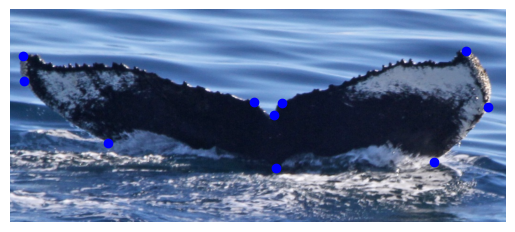

In [ ]:
index = 12
plt.imshow(images[index])
plt.axis('off')
x = [point for point in keypoints[index][::2]]
y = [point for point in keypoints[index][1::2]]
plt.scatter(x, y, c ="blue")
plt.show()

In [11]:
IMAGE_SIZE = 224
transform = A.Compose([
    A.Resize(width=IMAGE_SIZE, height=IMAGE_SIZE)
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

In [12]:
# because image have not same size and tensorflow need same size to find
def preprocess(image,keypoint):
    x = [point for point in keypoint[::2]]
    y = [point for point in keypoint[1::2]]
    keypoint = [[x[i],y[i]] for i in range(len(x))]
    transformed = transform(image=image,keypoints=keypoint)
    # print(transformed['image'],transformed['keypoints'])
    new_keypoint  = []
    for list in transformed['keypoints']:
        for item in list:
            new_keypoint.append(item)
    return transformed['image'],new_keypoint

x = []
y = []

for i in tqdm(range(len(images)),ncols=100):
    # print(i)
    image = images[i]
    keypoint = keypoints[i]
    new_image,new_keypoint = preprocess(image,keypoint)

    x.append(new_image)
    y.append(new_keypoint)

x = np.array(x)
y = np.array(y)
# print(x[0],y[0])

100%|███████████████████████████████████████████████████████████| 998/998 [00:00<00:00, 1955.01it/s]


In [13]:
x_train, x_test_val, y_train, y_test_val = train_test_split(x, y, test_size=0.2, random_state=42)
x_val,x_test,y_val,y_test = train_test_split(x_test_val, y_test_val, test_size=0.5, random_state=42)
print(len(x_train),len(x_val),len(x_test),len(y_train),len(y_val),len(y_test))

798 100 100 798 100 100


In [ ]:
print(y_train.shape)

(798, 20)


In [ ]:
tf.keras.backend.clear_session()
model = Sequential([
    InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPool2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPool2D((2, 2)),
    Flatten(),
    BatchNormalization(),
    #  relu เพราะ พิกัดติดลบไม่ได้ เเละเป็นการห่าพิกัดจุด เป็นปัญหา regression 
    Dense(256, activation='relu'),
    # Output 10 pairs of xy
    Dense(20)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100352)              │         401,408 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │           5,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,190,164 (99.91 MB)

 Trainable params: 25,989,460 (99.14 MB)

 Non-trainable params: 200,704 (784.00 KB)

In [ ]:
# regression loss (huber) จะเลือกใช้ MSE หรือ MAE ตามค่า error (ytrue - ypred) ในเเต่ละ Epoch เเละ ปรับ weigth ตาม loss ด้วย otimipized
model.compile(optimizer='adam', loss='huber',metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=100)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 374ms/step - accuracy: 0.1641 - loss: 75.2000 - val_accuracy: 0.0500 - val_loss: 127.1261
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3572 - loss: 31.9052 - val_accuracy: 0.3400 - val_loss: 84.8106
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4537 - loss: 19.0208 - val_accuracy: 0.5500 - val_loss: 81.1170
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4897 - loss: 17.3261 - val_accuracy: 0.5400 - val_loss: 64.7669
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5481 - loss: 13.8302 - val_accuracy: 0.3800 - val_loss: 54.0990
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5674 - loss: 11.4456 - val_accuracy: 0.4300 - val_loss: 84.0323
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5861 - loss: 10.6572 - val_accuracy: 0.4000 - val_loss: 44.3477
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5766 - loss: 9.4682 -

In [ ]:
model.save("model.keras")

In [5]:
model = load_model("model.keras")

In [ ]:
model.evaluate(x_test, y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 357ms/step - accuracy: 0.5622 - loss: 10.9882


[11.075247764587402, 0.5799999833106995]

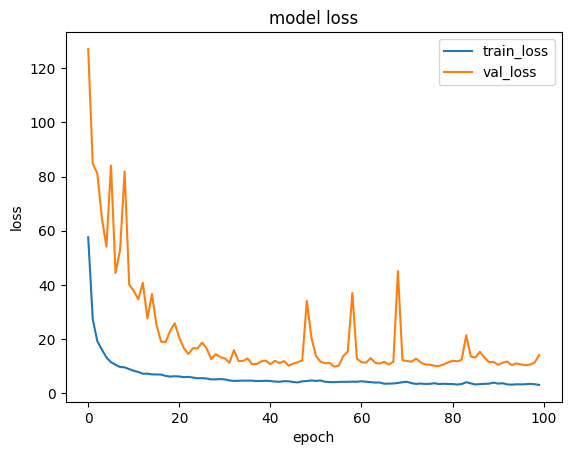

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss","val_loss"])
plt.show()

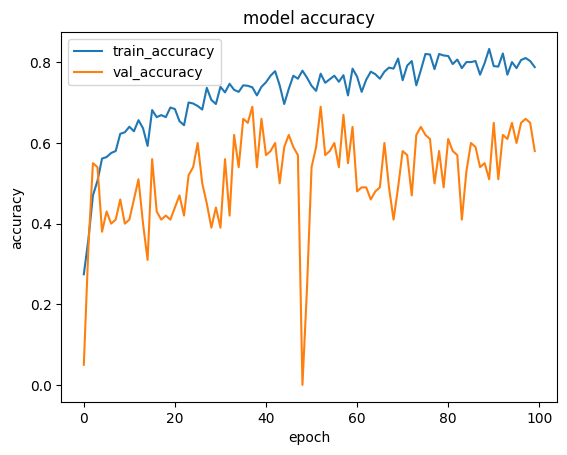

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train_accuracy","val_accuracy"])
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


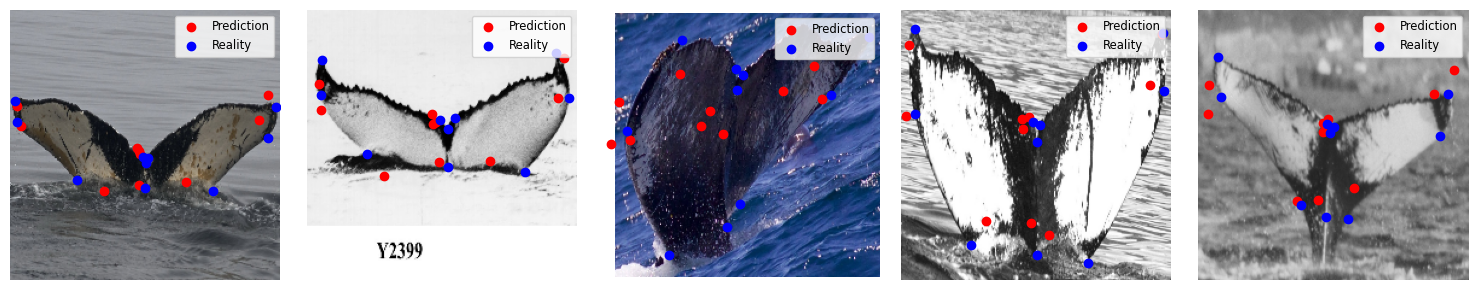

In [15]:
result = model.predict(x_test)

num_images =5
cols = 5
rows = (num_images + cols - 1) // cols

# Create a figure and a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
axes = axes.flatten()

for i in range(num_images):
    ax = axes[i]
    ax.imshow(x_test[i])
    ax.axis('off')

    x1 = [point for point in result[i][::2]]
    y1 = [point for point in result[i][1::2]]
    x2 = [point for point in y_test[i][::2]]
    y2 = [point for point in y_test[i][1::2]]


    ax.scatter(x1, y1, c="red", label="Prediction")
    ax.scatter(x2, y2, c="blue", label="Reality")

    ax.legend(loc="upper right", fontsize="small")

for j in range(num_images, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()